In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO: ENTRADA ALTAMENTE CORRELACIONADA ---
np.random.seed(42)
n_samples = 4000
order = 7  # M=7 (8 taps)

# Criando um sinal correlacionado (Filtro AR de banda estreita)
# Isso geralmente "quebra" a performance do LMS comum
b_ar, a_ar = [1], [1, -1.6, 0.95] 
x_white = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)
x = signal.lfilter(b_ar, a_ar, x_white)
x /= np.std(x) # Normalizando a variância

# Planta Desconhecida
w_true = np.array([0.1, 0.5, -0.3, 0.2, 0.4, -0.1, 0.1, -0.05], dtype=complex)
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.01 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO T-DOMAIN DCT ---
# gamma: regularização (evita divisão por zero)
# alpha: fator de esquecimento para a estimativa de potência (0.01 a 0.1)
filt_dct = pdf.TDomainDCT(
    filter_order=order,
    gamma=1e-4,
    alpha=0.05,
    initial_power=1.0,
    step_size=0.05
)

result = filt_dct.optimize(x, d, verbose=True, return_internal_states=True)

[TDomainDCT] Completed in 35.619 ms


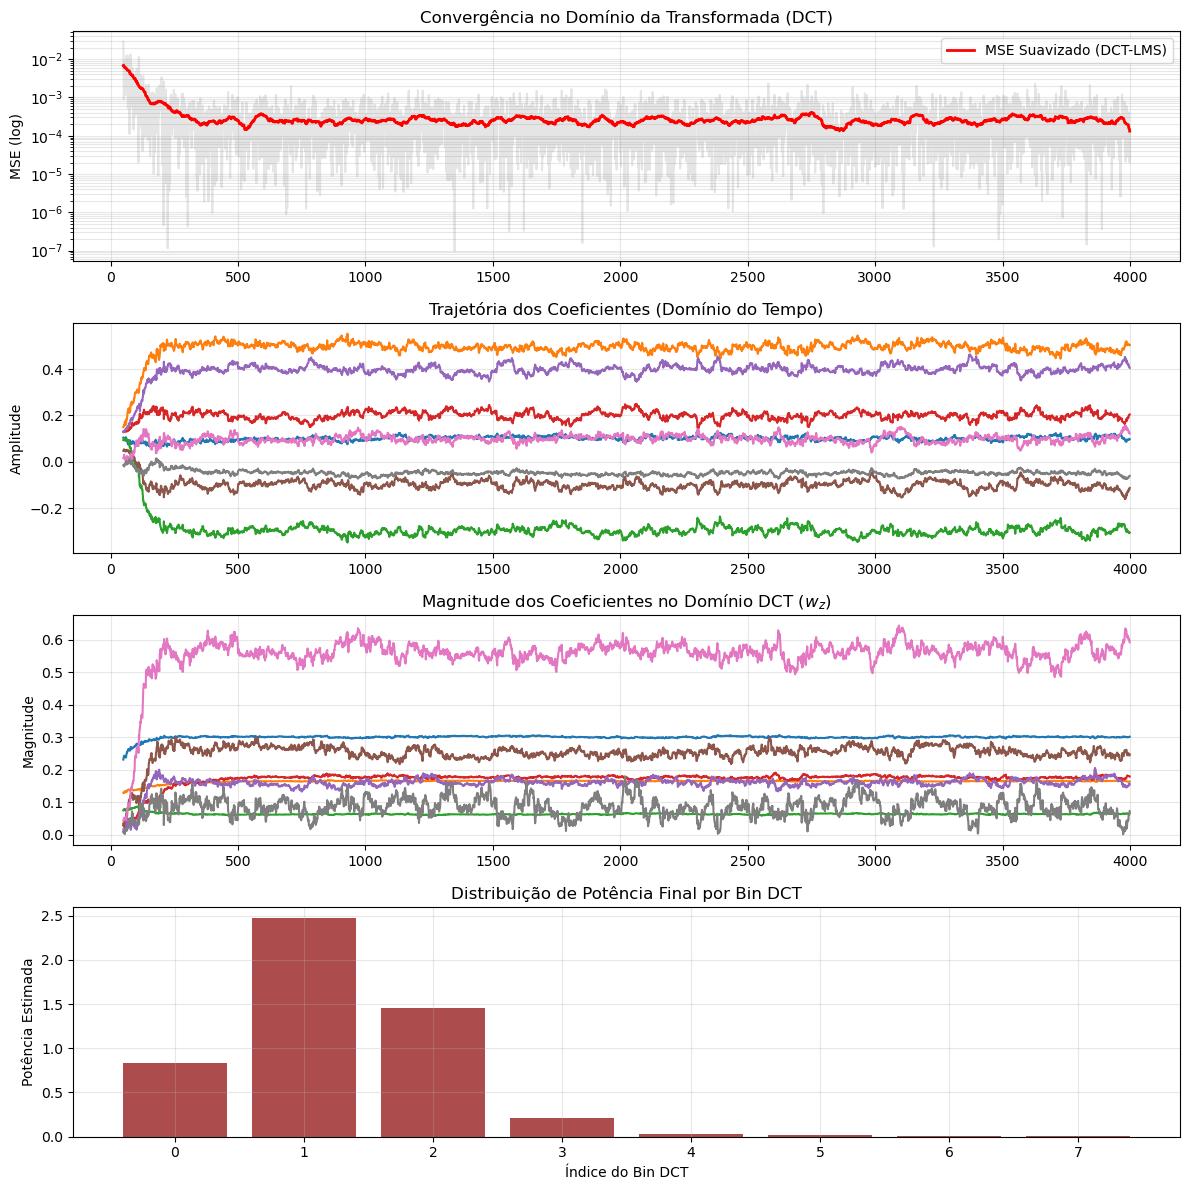

In [3]:
# --- 3. ANÁLISE VISUAL ---
offset = 50
mse = result.mse()
t = np.arange(len(mse))
coeffs_time = result.coefficients[1:] # Coeficientes no tempo (recuperados via T.T)
coeffs_dct = result.extra["coefficients_dct"][1:] # Coeficientes no domínio DCT

plt.figure(figsize=(12, 12))

# Subplot 1: MSE (Aprendizado)
plt.subplot(4, 1, 1)
plt.semilogy(t[offset:], mse[offset:], alpha=0.2, color='gray')
mse_smooth = np.convolve(mse, np.ones(50)/50, mode='same')
plt.semilogy(t[offset:], mse_smooth[offset:], label='MSE Suavizado (DCT-LMS)', color='red', lw=2)
plt.title('Convergência no Domínio da Transformada (DCT)')
plt.ylabel('MSE (log)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Pesos no Domínio do Tempo (w)
plt.subplot(4, 1, 2)
for i in range(coeffs_time.shape[1]):
    plt.plot(t[offset:], np.real(coeffs_time[offset:, i]), label=f'$w_{i}$')
plt.title('Trajetória dos Coeficientes (Domínio do Tempo)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

# Subplot 3: Pesos no Domínio da Transformada (w_z)
plt.subplot(4, 1, 3)
for i in range(coeffs_dct.shape[1]):
    plt.plot(t[offset:], np.abs(coeffs_dct[offset:, i]), label=f'$z_{i}$')
plt.title('Magnitude dos Coeficientes no Domínio DCT ($w_z$)')
plt.ylabel('Magnitude')
plt.grid(True, alpha=0.3)

# Subplot 4: Estimativa de Potência por Bin
plt.subplot(4, 1, 4)
p_last = result.extra["power_vector_last"]
plt.bar(range(len(p_last)), p_last, color='darkred', alpha=0.7)
plt.title('Distribuição de Potência Final por Bin DCT')
plt.xlabel('Índice do Bin DCT')
plt.ylabel('Potência Estimada')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()